1. Basic Data Overview

Load Package

In [70]:
!pip install -q pandas numpy matplotlib seaborn wordcloud vaderSentiment scikit-learn

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from matplotlib.ticker import ScalarFormatter, FuncFormatter
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

Basic Data Overview

In [80]:
df = pd.read_csv("ChatGPT_Review.csv", low_memory=False)

print(f"Loaded {len(df):,} rows with {len(df.columns)} columns.")

# Preview
print("\nPreview of first 5 rows ")
print(df.head(5).to_string(index=False))

# Missing values
print("\nMissing Value ")
print(df.isna().sum())

print("\nColumn Info ")
print(df.dtypes)


Loaded 1,477,847 rows with 11 columns.

Preview of first 5 rows 
                            reviewId            userName                                                                                         userImage                                                    content  score  thumbsUpCount reviewCreatedVersion                  at replyContent repliedAt appVersion
fe0b730f-9906-4a34-a5cc-8cb2d78c6de3            AMINE Ft https://play-lh.googleusercontent.com/a/ACg8ocKVVumLaI8DyiS84RMdpjXPHX1ifVVHl03bWt9xbZmZBKhDmA=mo Everything need money and a very very limited conversation      1              0           1.2025.273 2025-10-07 21:25:07          NaN       NaN 1.2025.273
388036d8-6cb8-4072-9b4f-368237f6567d Ram Dayal (RED BOY)  https://play-lh.googleusercontent.com/a-/ALV-UjV3iGP0lHWqKaGn6Nes5HM5URhMMUG21GdsavY5nCGTKbTMZPc                                                very nice 👍      5              0           1.2025.273 2025-10-07 21:24:05          NaN       NaN 1.2025.273
47

2. Data Quality & Bias Check  

Missing value visualization

Text(0.5, 1.0, 'Missing Value Percentage by Column')

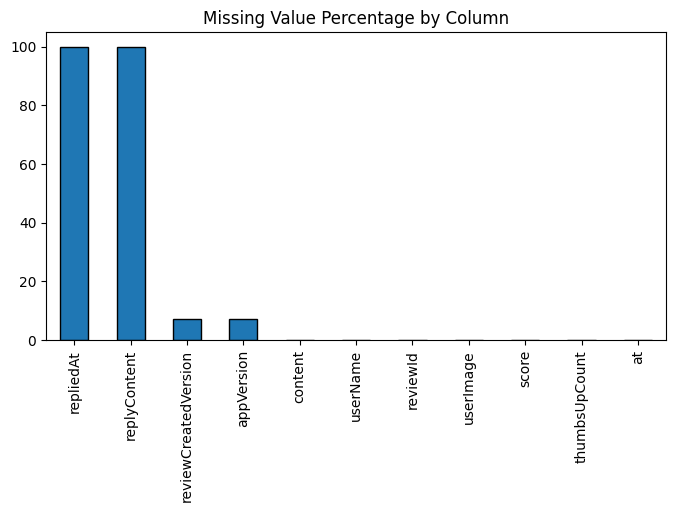

In [41]:
plt.figure(figsize=(8,4))
(df.isna().mean() * 100).sort_values(ascending=False).plot(kind='bar', edgecolor='black')
plt.title("Missing Value Percentage by Column")

Check Duplicate reviewId

In [42]:
dup_count = df["reviewId"].duplicated().sum()
print(f"Duplicate reviewId count: {dup_count}")

Duplicate reviewId count: 0


Count Active Users

In [76]:
if "userName" in df.columns:
    user_counts = df["userName"].value_counts()
    active_users = user_counts[user_counts > 1]
    print(f"Total unique users: {df['userName'].nunique()}")
    print(f"Users with >1 review: {len(active_users)} ({len(active_users)/df['userName'].nunique():.1%})")

    # Mark active users
    df["is_active_user"] = df["userName"].isin(active_users.index)

Total unique users: 1218901
Users with >1 review: 81301 (6.7%)


3. Rating Analysis  

Rating Distribution

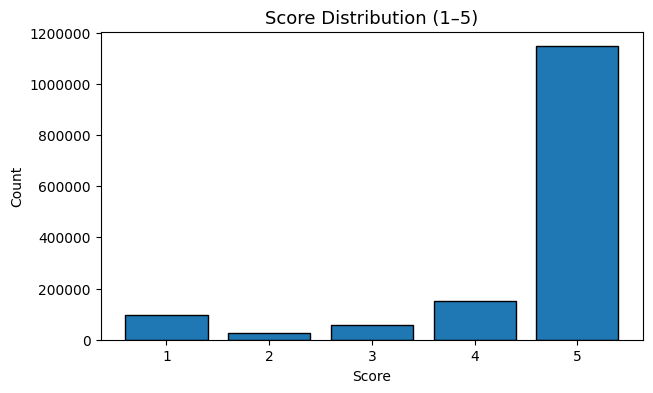

In [44]:
plt.figure(figsize=(7, 4))

counts = df["score"].value_counts(dropna=False).sort_index()

plt.bar(
    counts.index.astype(str),
    counts.values,
    edgecolor="black",
    linewidth=1.0
)

plt.title("Score Distribution (1–5)", fontsize=13)
plt.xlabel("Score")
plt.ylabel("Count")


plt.gca().yaxis.set_major_formatter(ScalarFormatter(useMathText=False))
plt.ticklabel_format(style='plain', axis='y')

plt.show()


4. Word Count Analysis  

Review Length Distribution

Text Length Stats
count    1.477847e+06
mean     6.299862e+00
std      1.118708e+01
min      1.000000e+00
25%      1.000000e+00
50%      3.000000e+00
75%      6.000000e+00
max      1.860000e+02
Name: word_count, dtype: float64


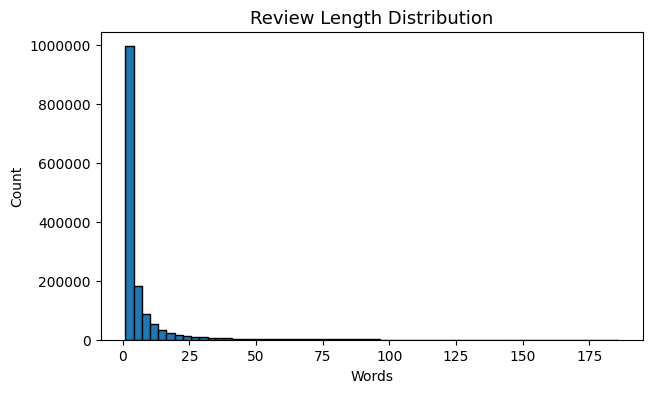

In [45]:
df["word_count"] = df["content"].astype(str).apply(lambda x: len(x.split()))

print("Text Length Stats")
print(df["word_count"].describe())

plt.figure(figsize=(7, 4))
plt.hist(df["word_count"].dropna(), bins=60, edgecolor="black", linewidth=1.0)

plt.title("Review Length Distribution", fontsize=13)
plt.xlabel("Words")
plt.ylabel("Count")

plt.gca().yaxis.set_major_formatter(ScalarFormatter())
plt.ticklabel_format(style="plain", axis="y")

plt.show()


Review Length by Rating


Average Review Length by Rating
            mean  median        std
score                              
1      12.194637     5.0  18.144930
2      12.769791     4.0  19.847179
3       9.357852     3.0  15.812078
4       7.347546     3.0  12.372073
5       5.358202     2.0   9.284719


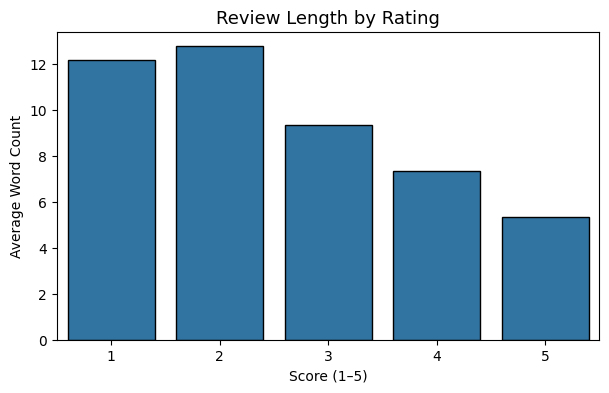

In [46]:
# Review Length by Rating

avg_len_by_score = df.groupby("score")["word_count"].agg(["mean", "median", "std"])

print("\nAverage Review Length by Rating")
print(avg_len_by_score)

plt.figure(figsize=(7, 4))
sns.barplot(
    x=avg_len_by_score.index,
    y=avg_len_by_score["mean"],
    edgecolor="black",
    linewidth=1.0
)

plt.title("Review Length by Rating", fontsize=13)
plt.xlabel("Score (1–5)")
plt.ylabel("Average Word Count")

plt.gca().yaxis.set_major_formatter(ScalarFormatter())
plt.ticklabel_format(style="plain", axis="y")

plt.show()

5. Sentiment Analysis

Sentiment Score

In [47]:
sid = SentimentIntensityAnalyzer()
df["content"] = df["content"].astype(str)
df["sentiment"] = df["content"].apply(lambda x: sid.polarity_scores(x)["compound"])
corr = pd.Series(df["sentiment"]).corr(pd.Series(df["score"]))
print(f"Pearson corr(sentiment, score) = {corr:.4f}")

Pearson corr(sentiment, score) = 0.3977


Sentiment Score & Rating over Time

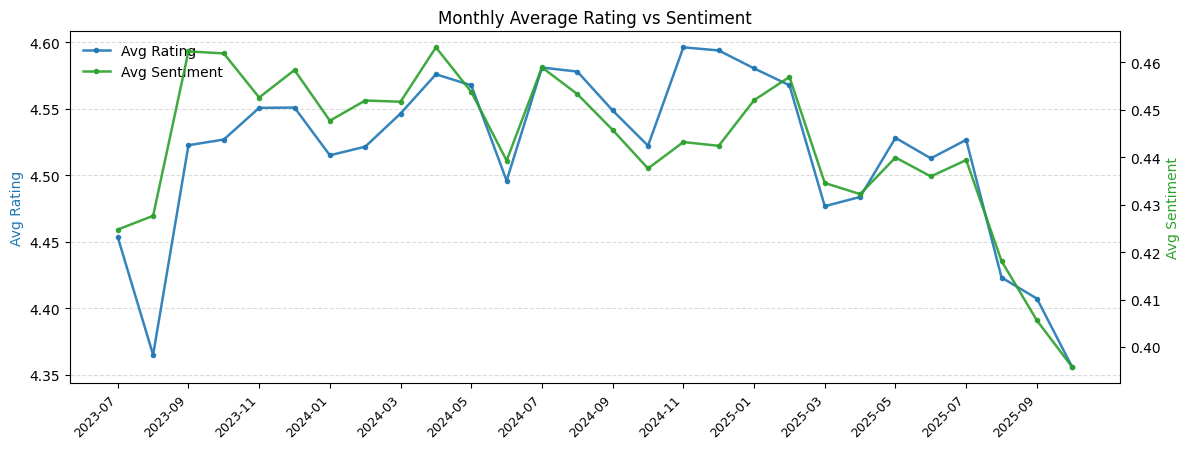

In [51]:
# Monthly Average Rating vs Sentiment
df["at"] = pd.to_datetime(df["at"], errors="coerce")
df["year_month"] = df["at"].dt.to_period("M")
all_months = pd.period_range(df["year_month"].min(), df["year_month"].max(), freq="M")

monthly = (df.groupby("year_month")
             .agg(mean_score=("score","mean"),
                  mean_sent=("sentiment","mean"))
             .reindex(all_months)
             .reset_index()
             .rename(columns={"index":"year_month"}))

xm = monthly["year_month"].astype(str)

fig, ax1 = plt.subplots(figsize=(12,4.6))

ax1.plot(xm, monthly["mean_score"],
         marker="o", markersize=3, linewidth=1.8, alpha=0.9,
         label="Avg Rating", color="#1f77b4")
ax1.set_ylabel("Avg Rating", color="#1f77b4")

ax2 = ax1.twinx()
ax2.plot(xm, monthly["mean_sent"],
         marker="o", markersize=3, linewidth=1.8, alpha=0.9,
         label="Avg Sentiment", color="#2ca02c")
ax2.set_ylabel("Avg Sentiment", color="#2ca02c")

step = max(1, len(xm)//12)
ax1.set_xticks(range(0, len(xm), step), xm[::step], rotation=45, ha="right", fontsize=9)

ax1.grid(axis="y", linestyle="--", alpha=0.45)
plt.title("Monthly Average Rating vs Sentiment")
plt.box(False)

l1, lb1 = ax1.get_legend_handles_labels()
l2, lb2 = ax2.get_legend_handles_labels()
ax1.legend(l1+l2, lb1+lb2, loc="upper left", frameon=False)

plt.tight_layout()
plt.show()

Correlation Between Sentiment and Rating by Month

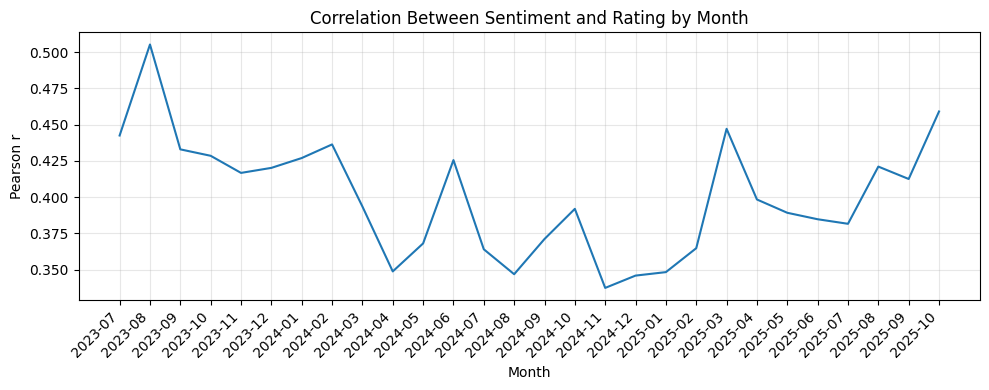

In [52]:
corr_by_month = df.groupby(df["at"].dt.to_period("M"))[["score","sentiment"]].corr().unstack().iloc[:,1]
plt.figure(figsize=(10,4))
plt.plot(corr_by_month.index.astype(str), corr_by_month.values)
plt.title("Correlation Between Sentiment and Rating by Month")
plt.ylabel("Pearson r")
plt.xlabel("Month")
plt.xticks(rotation=45, ha="right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Sentiment Distribution by Rating

/tmp/ipython-input-1300170643.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


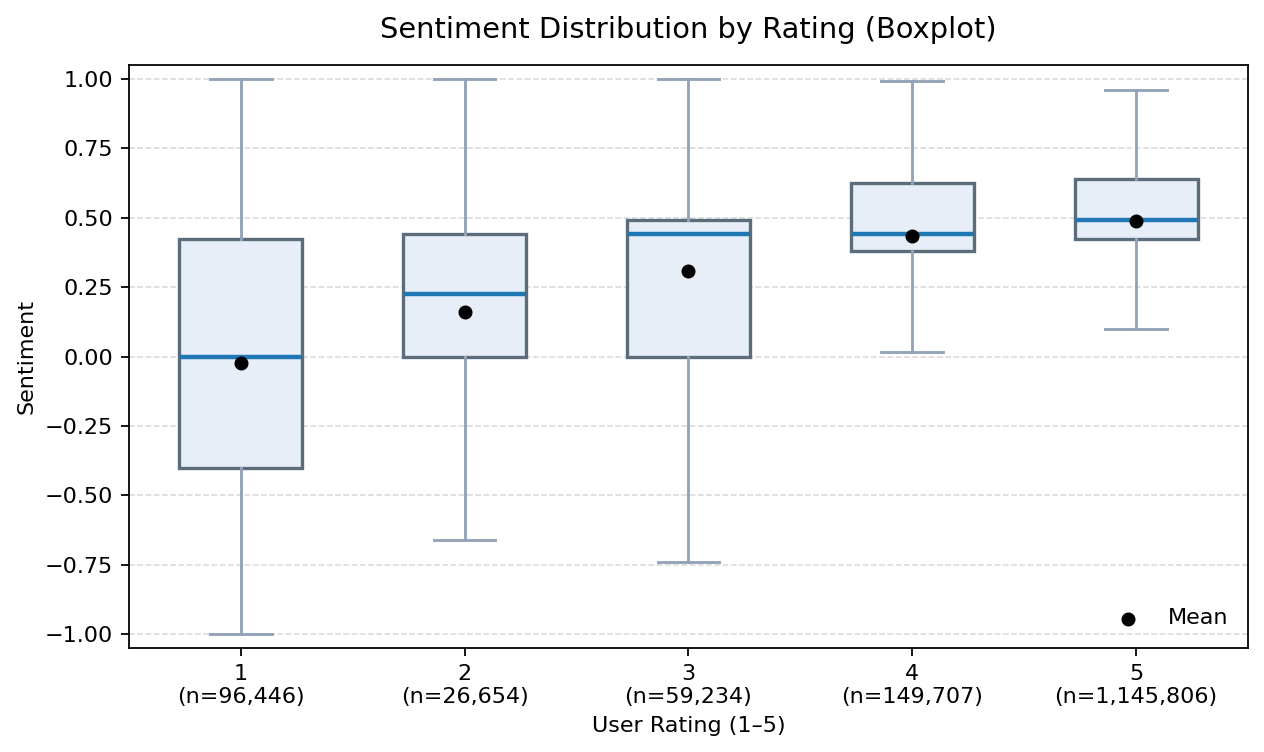

In [53]:
cand_cols = ["sentiment", "sentiment_vader_clean", "sentiment_vader_raw"]
sent_col = next((c for c in cand_cols if c in df.columns), None)
assert sent_col is not None, "No sentiment column found. Expected one of: " + ", ".join(cand_cols)
assert "score" in df.columns, "Missing column: score"

plot_df = df[[sent_col, "score"]].dropna().copy()
plot_df["score"] = plot_df["score"].astype(int)
scores = [1, 2, 3, 4, 5]
data = [plot_df.loc[plot_df["score"] == s, sent_col].values for s in scores]
counts = [len(d) for d in data]
means  = [np.mean(d) if len(d) else np.nan for d in data]


plt.rcParams["figure.dpi"] = 160
fig, ax = plt.subplots(figsize=(8, 4.8))

# boxplot with custom props
box = ax.boxplot(
    data,
    labels=[str(s) for s in scores],
    showfliers=False,
    patch_artist=True,
    widths=0.55
)


box_face = "#e8eef8"
box_edge = "#5b6d7a"
median_col = "#1f77b4"
whisker_col = "#94a3b8"
cap_col = "#94a3b8"

for patch in box["boxes"]:
    patch.set(facecolor=box_face, edgecolor=box_edge, linewidth=1.5)

for whisker in box["whiskers"]:
    whisker.set(color=whisker_col, linewidth=1.3)

for cap in box["caps"]:
    cap.set(color=cap_col, linewidth=1.3)

for median in box["medians"]:
    median.set(color=median_col, linewidth=2.0)

xpos = np.arange(1, len(scores) + 1)
ax.scatter(xpos, means, s=28, c="black", zorder=3, label="Mean")

xtick_labels = [f"{s}\n(n={c:,})" for s, c in zip(scores, counts)]
ax.set_xticklabels(xtick_labels)

ax.set_title("Sentiment Distribution by Rating (Boxplot)", pad=12, fontsize=13)
ax.set_xlabel("User Rating (1–5)")
ax.set_ylabel("Sentiment")
ax.set_ylim(-1.05, 1.05)
ax.yaxis.grid(True, linestyle="--", linewidth=0.7, alpha=0.5)
ax.set_axisbelow(True)
ax.legend(loc="lower right", frameon=False)

plt.tight_layout()
plt.show()

WordCloud by Rating Level

Top Words BEFORE Stopword Removal            
Positive Reviews (Score ≥ 4)                  Negative Reviews (Score ≤ 2)
------------------------------------------------------------------------------------------
good            327071         | the             40250 
app             281146         | and             32155 
very            247123         | app             25558 
and             160181         | not             23643 
the             144512         | this            20277 
nice            142819         | good            18374 
this            139655         | for             15410 
best            134138         | very            15357 
for             108251         | its             13846 
its             103660         | but             12220 
you             64605          | you             11504 
helpful         63727          | that            8663  
great           60629          | bad             8412  
love            55285          | time            7354  
amaz

/tmp/ipython-input-335629299.py:73: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("RdBu")


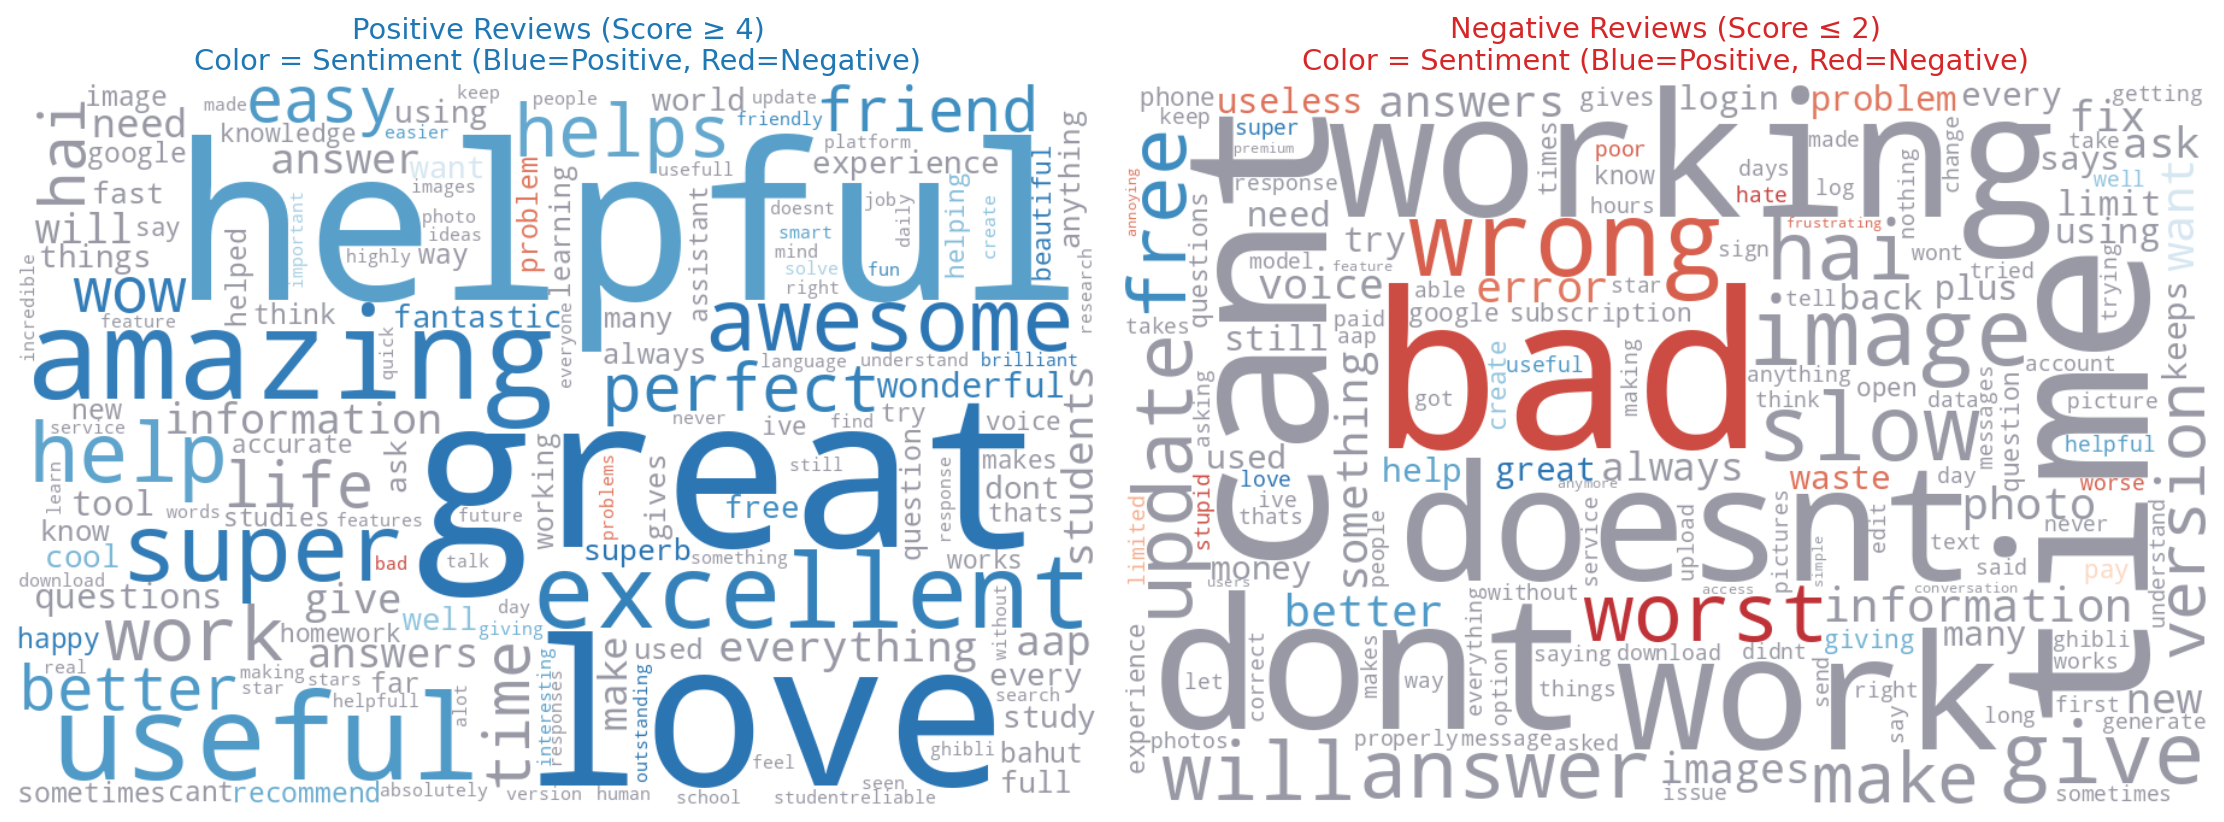

In [54]:
# Define stopwords
custom_stopwords = set(STOPWORDS)
custom_stopwords.update([
    "app", "chatgpt", "chat", "gpt", "chat gpt", "ai", "bot",
    "nice", "good", "use", "really", "thing", "much", "best", "lot", "even",
    "its", "you", "that", "one", "and", "the", "this", "for", "very", "now",
    "please", "thank", "thanks", "application", "apps"
])

# Clean text
def clean_text(t):
    t = str(t).lower()
    t = re.sub(r"http\S+|www\S+", "", t)
    t = re.sub(r"[^a-z\s]", "", t)
    t = re.sub(r"\s+", " ", t).strip()
    return t

df["clean_content"] = df["content"].apply(clean_text)

# Split by sentiment group
pos_text_raw = " ".join(df.loc[df["score"] >= 4, "clean_content"].dropna())
neg_text_raw = " ".join(df.loc[df["score"] <= 2, "clean_content"].dropna())

# Raw word frequencies
def get_raw_freq(text, min_len=3):
    words = [w for w in text.split() if len(w) >= min_len]
    return dict(Counter(words).most_common(200))

raw_pos_freq = get_raw_freq(pos_text_raw)
raw_neg_freq = get_raw_freq(neg_text_raw)

top_n = 20
pos_top_raw = list(raw_pos_freq.items())[:top_n]
neg_top_raw = list(raw_neg_freq.items())[:top_n]

print("Top Words BEFORE Stopword Removal".ljust(45))
print("Positive Reviews (Score ≥ 4)".ljust(45), "Negative Reviews (Score ≤ 2)")
print("-" * 90)
for i in range(top_n):
    left = f"{pos_top_raw[i][0]:<15} {pos_top_raw[i][1]:<6}" if i < len(pos_top_raw) else ""
    right = f"{neg_top_raw[i][0]:<15} {neg_top_raw[i][1]:<6}" if i < len(neg_top_raw) else ""
    print(f"{left:<30} | {right}")

# Filtered frequencies (AFTER removing stopwords)
def get_filtered_freq(text, stopwords, min_len=3):
    words = [w for w in text.split() if w not in stopwords and len(w) >= min_len]
    return dict(Counter(words).most_common(200))

freq_pos = get_filtered_freq(pos_text_raw, custom_stopwords)
freq_neg = get_filtered_freq(neg_text_raw, custom_stopwords)


print("\n Top Words AFTER Stopword Removal")
print("Positive Reviews (Score ≥ 4)".ljust(45), "Negative Reviews (Score ≤ 2)")
print("-" * 90)
pos_top = list(freq_pos.items())[:top_n]
neg_top = list(freq_neg.items())[:top_n]
for i in range(top_n):
    left = f"{pos_top[i][0]:<15} {pos_top[i][1]:<6}" if i < len(pos_top) else ""
    right = f"{neg_top[i][0]:<15} {neg_top[i][1]:<6}" if i < len(neg_top) else ""
    print(f"{left:<30} | {right}")

# Sentiment-based coloring
analyzer = SentimentIntensityAnalyzer()
word_sent = {w: analyzer.polarity_scores(w)["compound"] for w in set(freq_pos) | set(freq_neg)}


def color_by_sentiment(word, font_size, position, orientation, random_state=None, **kwargs):

    s = word_sent.get(word, 0.0)
    s = np.sign(s) * (abs(s) ** 0.7)

    cmap = cm.get_cmap("RdBu")
    rgba = cmap((s + 1) / 2)


    if abs(s) < 0.15:
        rgba = (0.6, 0.6, 0.65, 1.0)

    r, g, b, a = [int(x * 255) for x in rgba]
    return f"rgb({r},{g},{b})"

# Generate word clouds
wc_pos = WordCloud(width=900, height=600, background_color="white",
                   stopwords=custom_stopwords, max_words=150, max_font_size=180
                  ).generate_from_frequencies(freq_pos)

wc_neg = WordCloud(width=900, height=600, background_color="white",
                   stopwords=custom_stopwords, max_words=150, max_font_size=180
                  ).generate_from_frequencies(freq_neg)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].imshow(wc_pos.recolor(color_func=color_by_sentiment, random_state=3), interpolation="bilinear")
axes[0].set_title("Positive Reviews (Score ≥ 4)\nColor = Sentiment (Blue=Positive, Red=Negative)",
                  fontsize=13, color="#1f77b4")
axes[0].axis("off")

axes[1].imshow(wc_neg.recolor(color_func=color_by_sentiment, random_state=3), interpolation="bilinear")
axes[1].set_title("Negative Reviews (Score ≤ 2)\nColor = Sentiment (Blue=Positive, Red=Negative)",
                  fontsize=13, color="#d62728")
axes[1].axis("off")

plt.tight_layout()
plt.show()


Sarcastic Reviews

In [55]:
#Sarcastic reviews
sarcastic = df[(df["score"] == 1) & (df["sentiment"] > 0.5)]

if len(sarcastic) > 0:
    print(f"Detected {len(sarcastic)} potentially sarcastic or misclassified comments.\n")
    print("First 5 examples (full text):\n")

    for i, row in sarcastic.head(5).iterrows():
        print(f"- {row['content']}")
        print(f"  (sent={row['sentiment']:.2f}, score={row['score']}, version={row.get('reviewCreatedVersion', 'N/A')})\n")
else:
    print("No sarcastic or misclassified comments found.")

Detected 10866 potentially sarcastic or misclassified comments.

First 5 examples (full text):

- its the best like fr
  (sent=0.77, score=1, version=1.2025.273)

- Very unstable for two months already. I pay for it for almost a year, but now I'm actively looking for another provider. I want to see clear boundaries & restrictions, as well as stable & expected performance. Instead, it's all different every week. I thought at first it was frustrating, but now I realize it's just a huge product issue that should be resolved before other labs finally get memories+TSS, and then I'll be gone 💨
  (sent=0.88, score=1, version=1.2025.273)

- was a great app until they stop letting you have creative freedom
  (sent=0.88, score=1, version=1.2025.273)

- If you want to waste your time trying to get it to help you with stuff then it's the perfect app.
  (sent=0.60, score=1, version=1.2025.273)

- Too much restrictions , and for free plan user's less daily conversation limit in or chat, out of uploa

Sarcastic / Misclassified Reviews by Month

/tmp/ipython-input-3691977529.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sarcastic["at"] = pd.to_datetime(sarcastic["at"], errors="coerce")
/tmp/ipython-input-3691977529.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sarcastic["year_month"] = sarcastic["at"].dt.to_period("M")


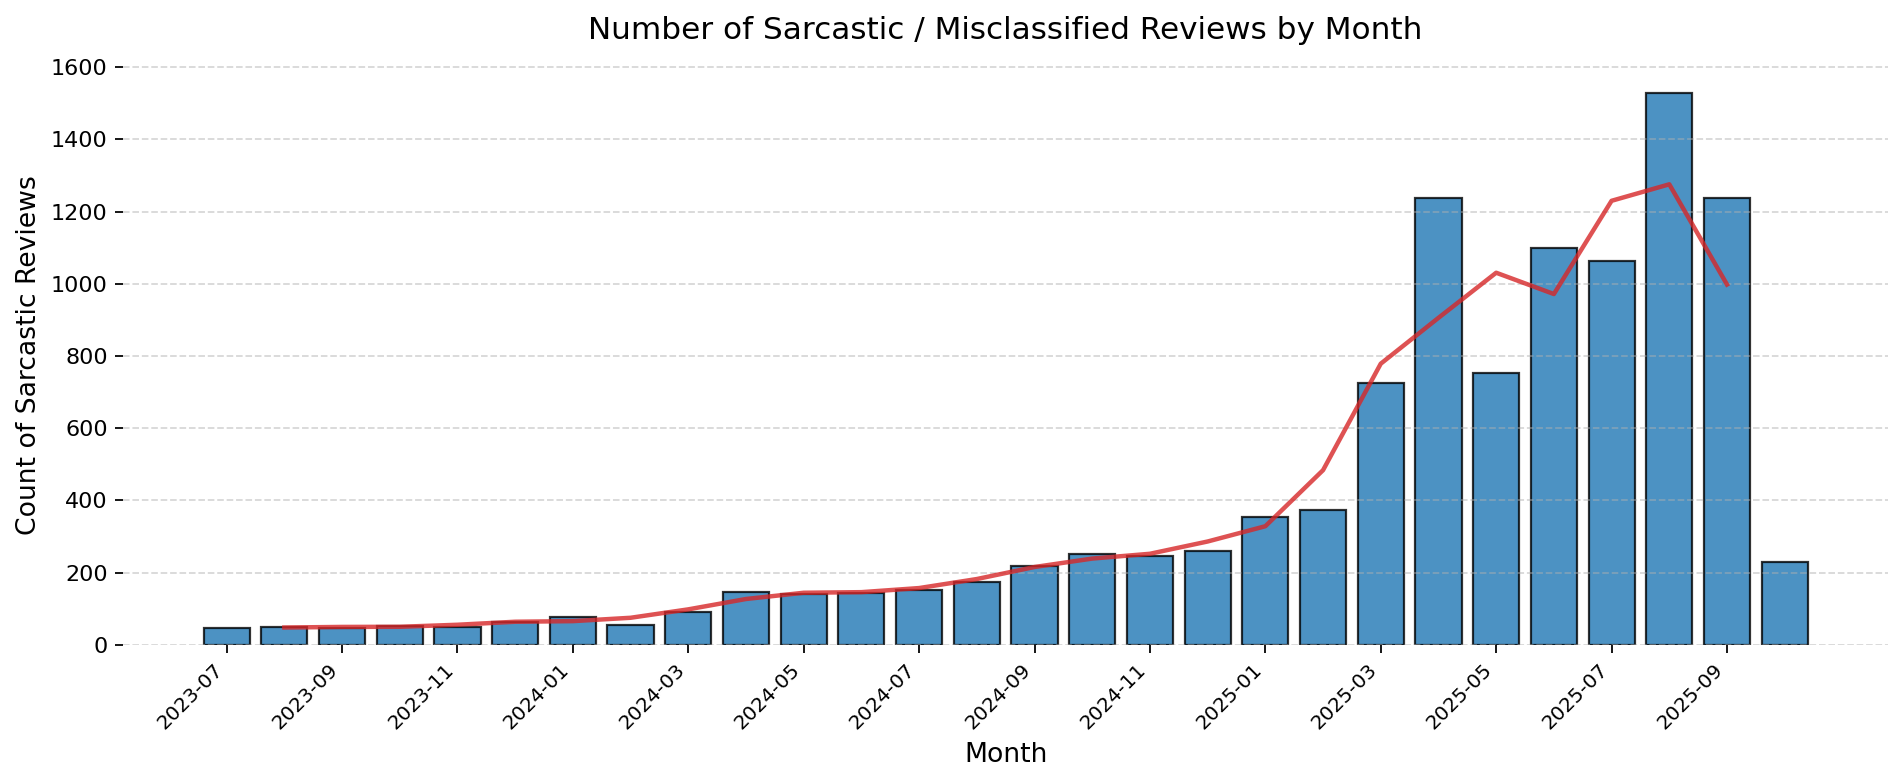

In [56]:
# Sarcastic / Misclassified Reviews by Month

df["at"] = pd.to_datetime(df["at"], errors="coerce")
sarcastic["at"] = pd.to_datetime(sarcastic["at"], errors="coerce")

df["year_month"] = df["at"].dt.to_period("M")
sarcastic["year_month"] = sarcastic["at"].dt.to_period("M")

all_months = pd.period_range(df["year_month"].min(), df["year_month"].max(), freq="M")

monthly_sarcasm = sarcastic.groupby("year_month")["reviewId"].count().reindex(all_months, fill_value=0)

trend = monthly_sarcasm.rolling(window=3, center=True).mean()

# Plot
plt.figure(figsize=(12,5))
plt.bar(monthly_sarcasm.index.astype(str), monthly_sarcasm.values, edgecolor="black", alpha=0.8, color="#1f77b4") # Changed color

x_labels = monthly_sarcasm.index.astype(str)
step = max(1, len(x_labels)//14)
plt.xticks(range(0, len(x_labels), step), x_labels[::step], rotation=45, ha="right", fontsize=9)

plt.plot(range(len(trend)), trend.values, color="#d62728", linewidth=2, alpha=0.8) # Changed color

plt.title("Number of Sarcastic / Misclassified Reviews by Month", fontsize=14, pad=12)
plt.ylabel("Count of Sarcastic Reviews", fontsize=12)
plt.xlabel("Month", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.box(False) # Removed box
plt.tight_layout()
plt.show()

Sarcastic / Misclassified Reviews by Version

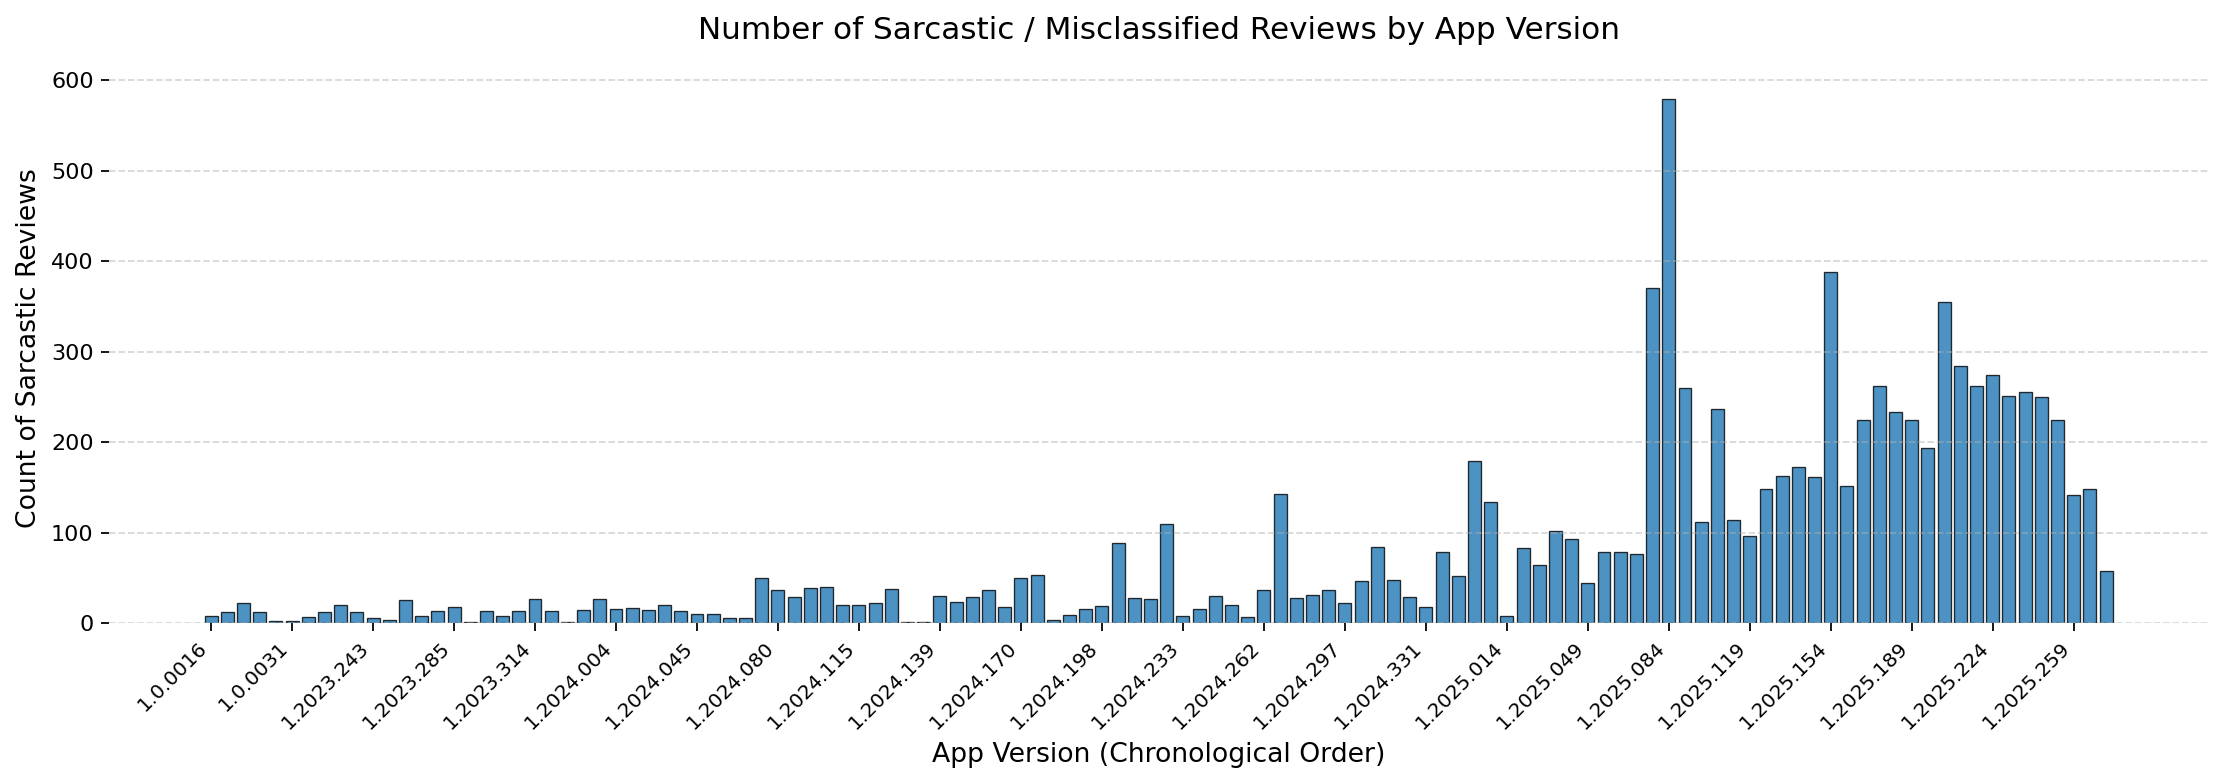


Top versions with the most sarcastic/misclassified reviews:
reviewCreatedVersion
1.2025.084    580
1.2025.154    388
1.2025.077    371
1.2025.203    355
1.2025.210    284
1.2025.224    274
1.2025.175    262
1.2025.217    262
1.2025.091    260
1.2025.238    256
Name: reviewId, dtype: int64


In [57]:
if "reviewCreatedVersion" in sarcastic.columns:
    version_sarcasm = sarcastic.groupby("reviewCreatedVersion")["reviewId"].count()

    def version_key(v):
        parts = re.findall(r'\d+', str(v))
        return tuple(map(int, parts)) if parts else (0,)
    version_sarcasm = version_sarcasm.sort_index(key=lambda x: x.map(version_key))

    plt.figure(figsize=(14,5))
    bars = plt.bar(
        version_sarcasm.index.astype(str),
        version_sarcasm.values,
        edgecolor="black",
        alpha=0.8,
        linewidth=0.6
    )

    plt.title("Number of Sarcastic / Misclassified Reviews by App Version", fontsize=14, pad=15)
    plt.ylabel("Count of Sarcastic Reviews", fontsize=12)
    plt.xlabel("App Version (Chronological Order)", fontsize=12)

    xticks = version_sarcasm.index.astype(str)
    step = max(1, len(xticks)//20)
    plt.xticks(range(0, len(xticks), step), xticks[::step], rotation=45, ha="right", fontsize=9)

    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.box(False)

    plt.tight_layout()
    plt.show()

    print("\nTop versions with the most sarcastic/misclassified reviews:")
    print(version_sarcasm.sort_values(ascending=False).head(10))

6. Time Trends  

Monthly Review Volume & Average Rating

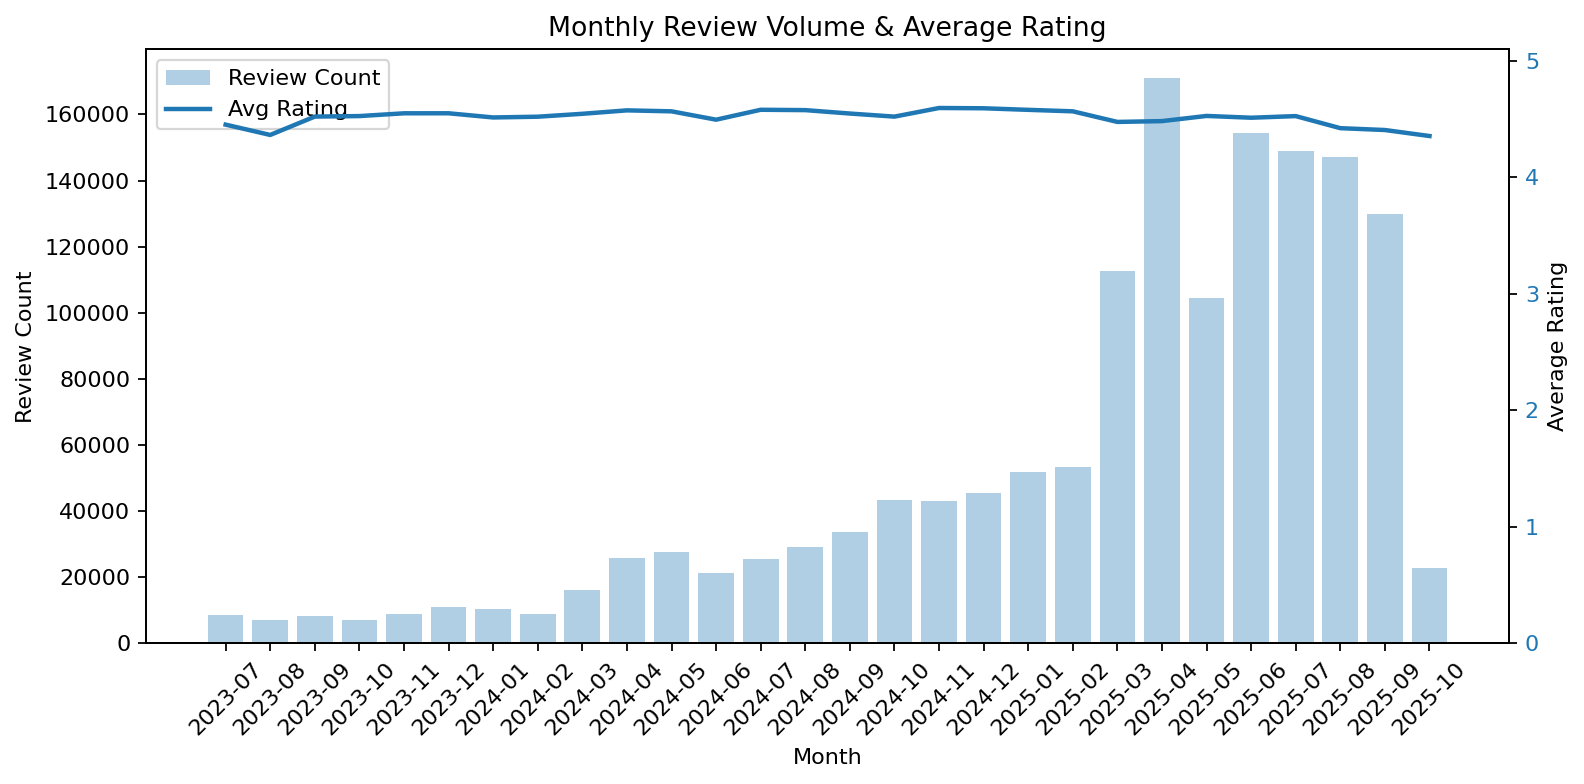

In [58]:
df["at"] = pd.to_datetime(df["at"], errors="coerce")

if df["at"].notna().any():
    df["month"] = df["at"].dt.to_period("M")
    monthly = df.groupby("month").agg(
        review_count=("reviewId", "count"),
        avg_score=("score", "mean")
    ).reset_index()

    fig, ax1 = plt.subplots(figsize=(10,5))

    # Bar: number of reviews
    ax1.bar(monthly["month"].astype(str), monthly["review_count"], alpha=0.35, label="Review Count")
    ax1.set_xlabel("Month")
    ax1.set_ylabel("Review Count")
    ax1.tick_params(axis="y", labelcolor="black")
    plt.xticks(rotation=45)

    # Line: average rating
    ax2 = ax1.twinx()
    ax2.plot(monthly["month"].astype(str), monthly["avg_score"], linewidth=2, color="tab:blue", label="Avg Rating")
    ax2.set_ylabel("Average Rating")
    ax2.set_ylim(0, 5.1)
    ax2.tick_params(axis="y", labelcolor="tab:blue")

    # Combined legend
    l1, lb1 = ax1.get_legend_handles_labels()
    l2, lb2 = ax2.get_legend_handles_labels()
    ax1.legend(l1+l2, lb1+lb2, loc="upper left")

    plt.title("Monthly Review Volume & Average Rating")
    plt.tight_layout()
    plt.show()

Average Review Length Over Time

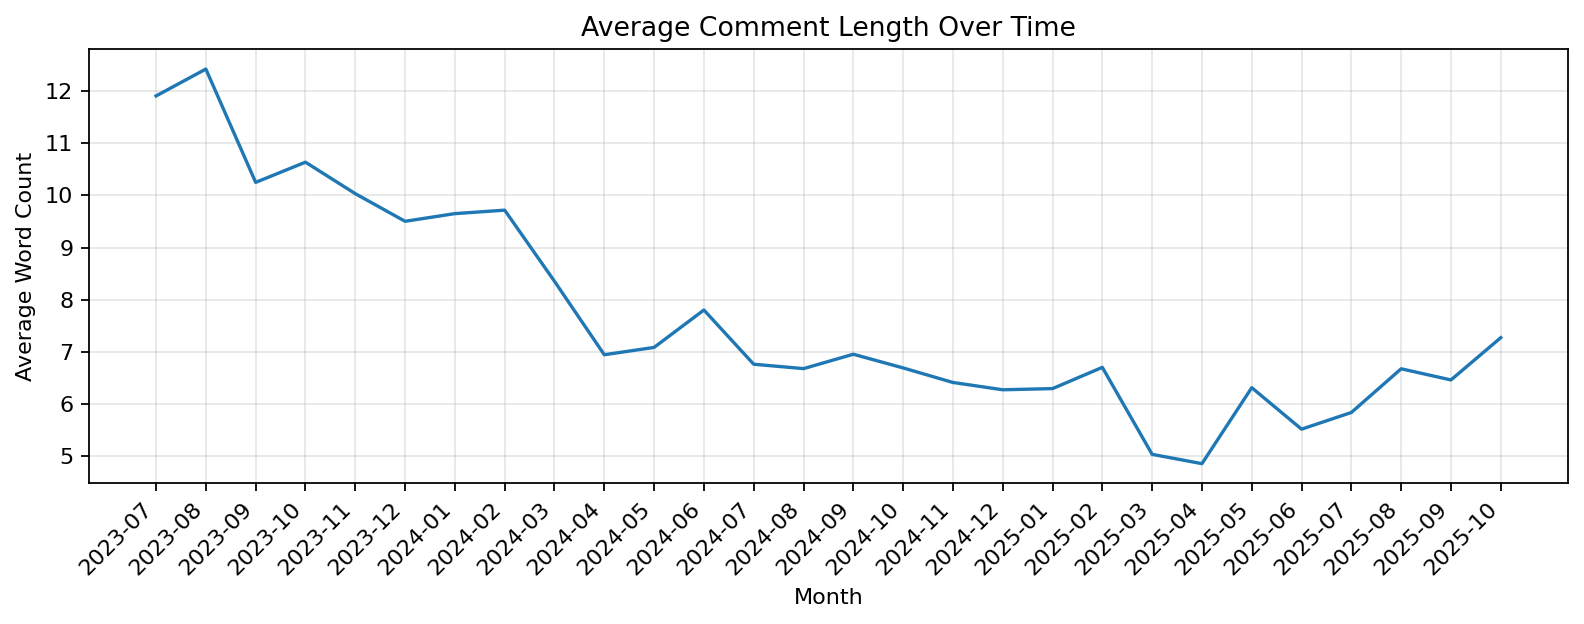

In [59]:
# Average Review Length Over Time
df["year_month"] = df["at"].dt.to_period("M")
monthly_length = df.groupby("year_month")["word_count"].mean()

plt.figure(figsize=(10,4))
plt.plot(monthly_length.index.astype(str), monthly_length.values)
plt.title("Average Comment Length Over Time")
plt.xlabel("Month")
plt.ylabel("Average Word Count")
plt.xticks(rotation=45, ha="right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

7. Version Trends  

Average Rating and Review Volume by Version

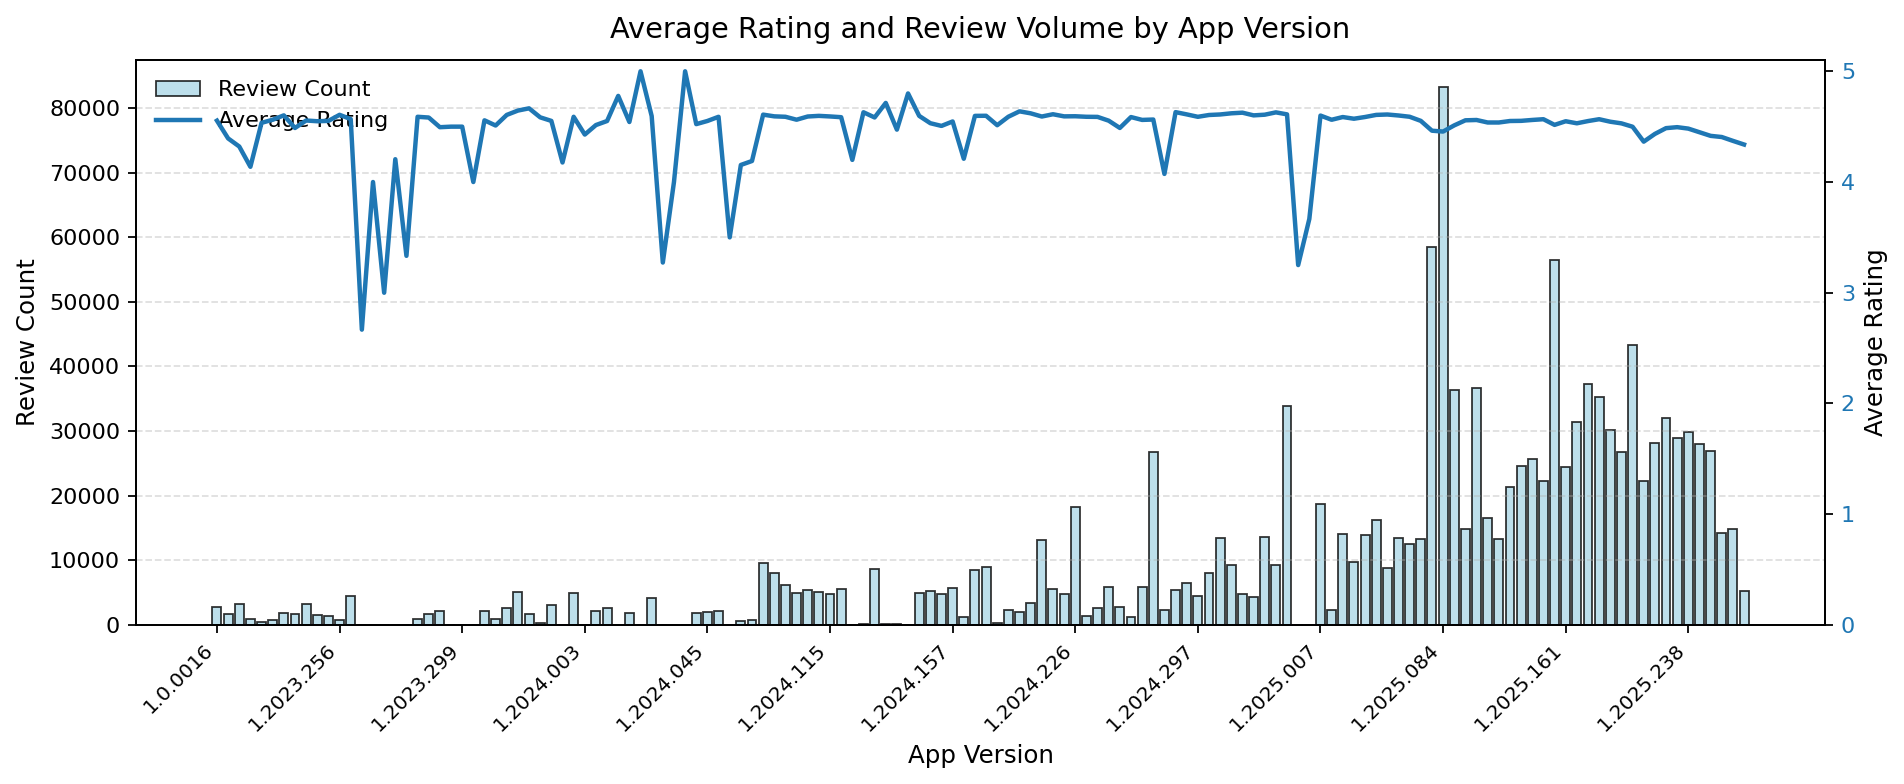

In [61]:
# Average Rating and Review Volume by App Version

version_df = (
    df.groupby("reviewCreatedVersion")
      .agg(
          review_count=("reviewId", "count"),
          avg_score=("score", "mean")
      )
      .reset_index()
      .dropna(subset=["reviewCreatedVersion"])
)

import re
def version_key(v):
    parts = re.findall(r'\d+', str(v))
    return tuple(map(int, parts)) if parts else (0,)

version_df = version_df.sort_values(
    "reviewCreatedVersion", key=lambda s: s.map(version_key)
).reset_index(drop=True)


fig, ax1 = plt.subplots(figsize=(12, 5))

ax1.bar(
    version_df["reviewCreatedVersion"].astype(str),
    version_df["review_count"],
    color="lightblue",
    alpha=0.8,
    label="Review Count",
    edgecolor="black",
    linewidth=0.8
)
ax1.set_ylabel("Review Count", fontsize=11)
ax1.set_xlabel("App Version", fontsize=11)
ax1.tick_params(axis="y", labelcolor="black")

xticks = version_df["reviewCreatedVersion"].astype(str).values
step = max(1, len(xticks) // 12)
ax1.set_xticks(range(0, len(xticks), step))
ax1.set_xticklabels(xticks[::step], rotation=45, ha="right", fontsize=9)


ax2 = ax1.twinx()
ax2.plot(
    range(len(version_df)),
    version_df["avg_score"],
    linewidth=2,
    color="tab:blue",
    label="Average Rating"
)
ax2.set_ylabel("Average Rating", fontsize=11)
ax2.set_ylim(0, 5.1)
ax2.tick_params(axis="y", labelcolor="tab:blue")

l1, lb1 = ax1.get_legend_handles_labels()
l2, lb2 = ax2.get_legend_handles_labels()
ax1.legend(l1 + l2, lb1 + lb2, loc="upper left", frameon=False)

ax1.grid(axis="y", linestyle="--", alpha=0.4)
plt.title("Average Rating and Review Volume by App Version", fontsize=13, pad=10)
plt.tight_layout()
plt.show()

Average Score & Sentiment by App Version

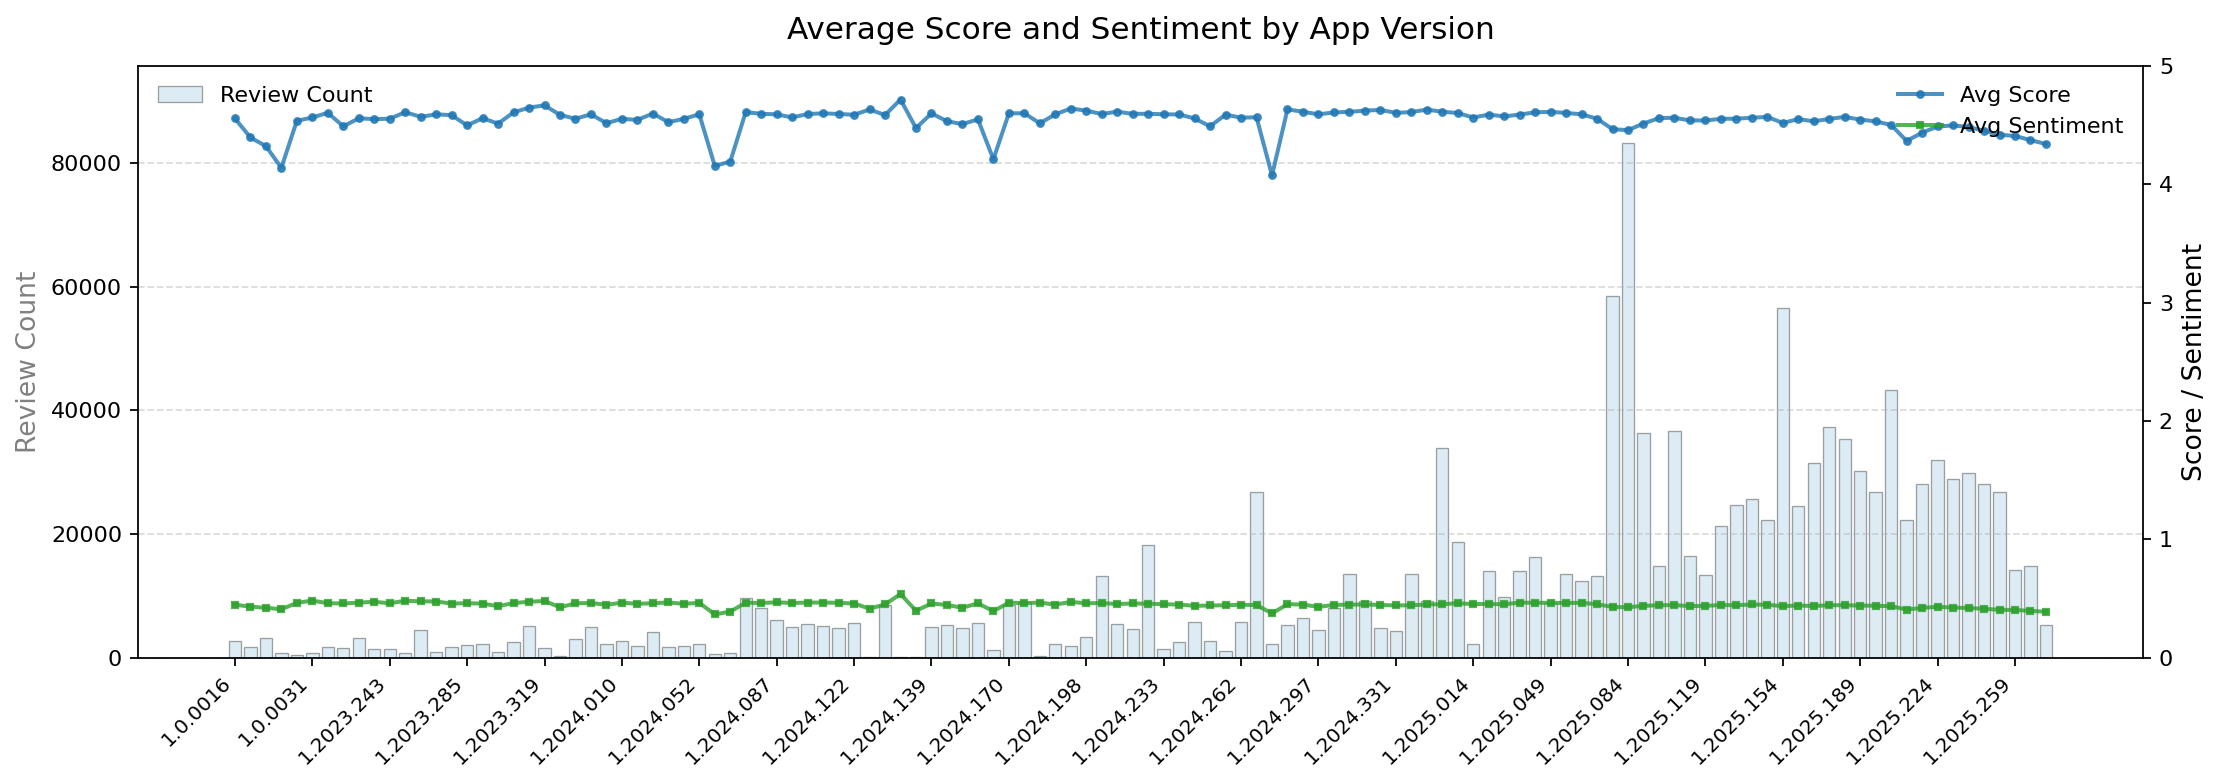

In [62]:
# Average Score & Sentiment by App Version

if "reviewCreatedVersion" in df.columns and "sentiment" in df.columns:
    version_sent = (
        df.groupby("reviewCreatedVersion")
          .agg(mean_score=("score", "mean"),
               mean_sent=("sentiment", "mean"),
               count=("reviewId", "count"))
          .reset_index()
          .dropna(subset=["reviewCreatedVersion"])
    )

    version_sent = version_sent[version_sent["count"] >= 50]

    def version_key(v):
        parts = re.findall(r'\d+', str(v))
        return tuple(map(int, parts)) if parts else (0,)
    version_sent = version_sent.sort_values(
        "reviewCreatedVersion", key=lambda s: s.map(version_key)
    ).reset_index(drop=True)

    fig, ax1 = plt.subplots(figsize=(14, 5))

    ax1.bar(
        version_sent["reviewCreatedVersion"].astype(str),
        version_sent["count"],
        edgecolor="black",
        alpha=0.35,
        linewidth=0.6,
        color="#9ecae1",
        label="Review Count"
    )
    ax1.set_ylabel("Review Count", fontsize=12, color="gray")

    xticks = version_sent["reviewCreatedVersion"].astype(str).values
    step = max(1, len(xticks)//20)
    ax1.set_xticks(range(0, len(xticks), step))
    ax1.set_xticklabels(xticks[::step], rotation=45, ha="right", fontsize=9)

    ax2 = ax1.twinx()
    ax2.plot(
        range(len(version_sent)), version_sent["mean_score"],
        marker="o", markersize=3, linewidth=1.8, alpha=0.8,
        label="Avg Score", color="#1f77b4"
    )
    ax2.plot(
        range(len(version_sent)), version_sent["mean_sent"],
        marker="s", markersize=3, linewidth=1.8, alpha=0.8,
        label="Avg Sentiment", color="#2ca02c"
    )
    ax2.set_ylim(0, 5)
    ax2.set_ylabel("Score / Sentiment", fontsize=12)

    ax1.grid(axis="y", linestyle="--", alpha=0.45)
    ax1.set_ylim(0, version_sent["count"].max() * 1.15)
    plt.title("Average Score and Sentiment by App Version", fontsize=14, pad=12)
    ax1.legend(loc="upper left", frameon=False)
    ax2.legend(loc="upper right", frameon=False)
    plt.box(False)
    plt.tight_layout()
    plt.show()

8. Word & N-gram Analysis  

Common Bigrams/Trigrams by Rating

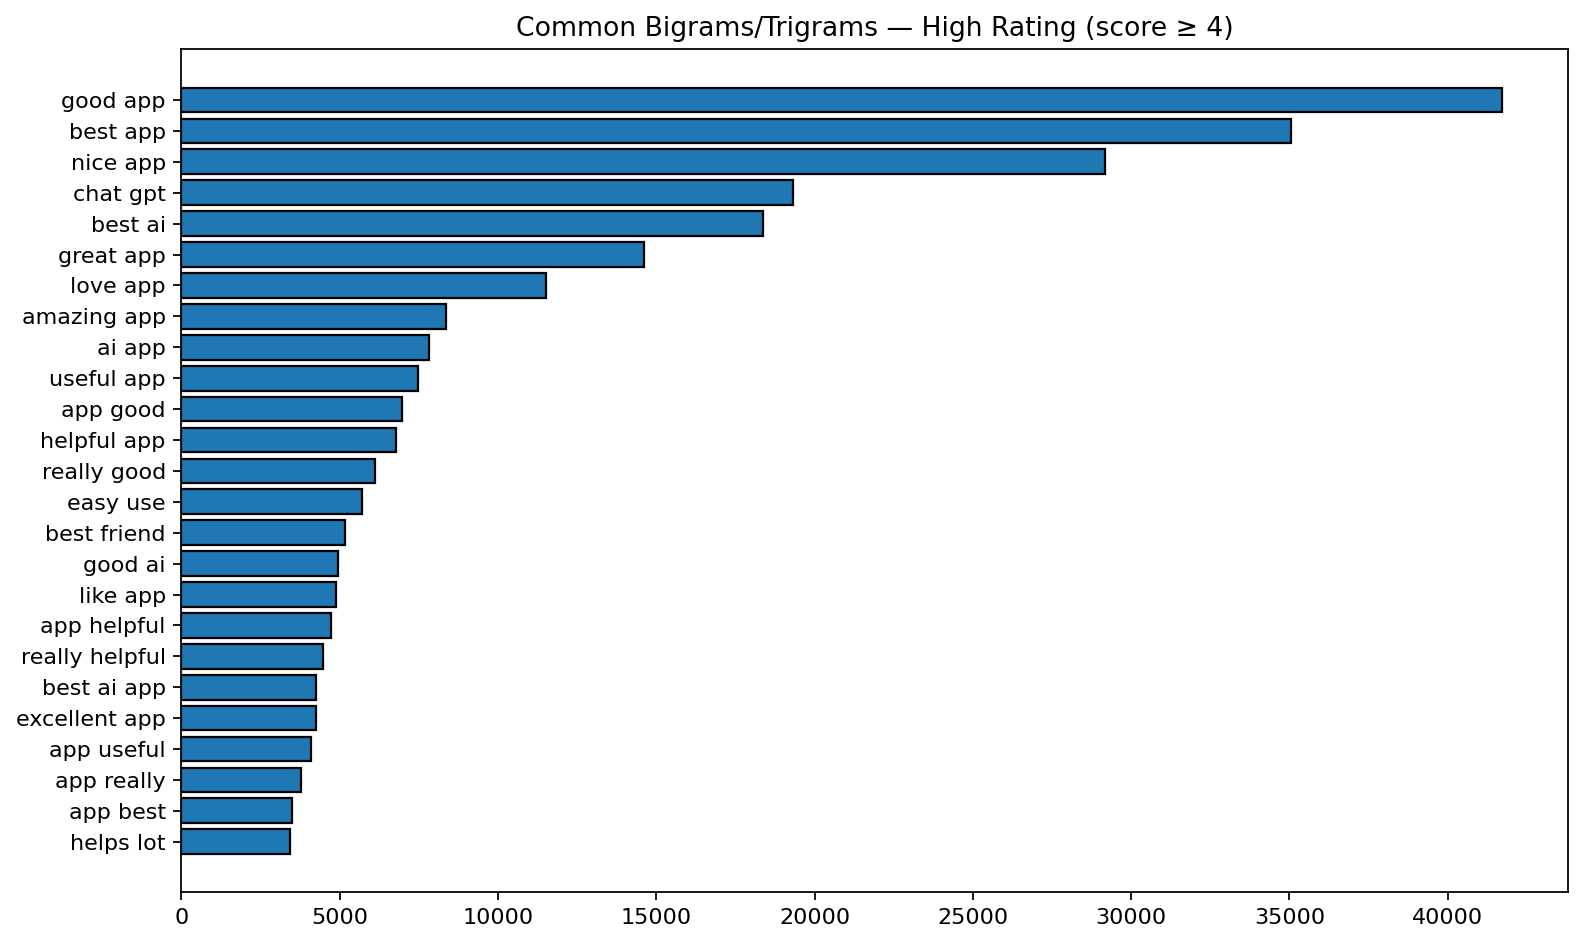

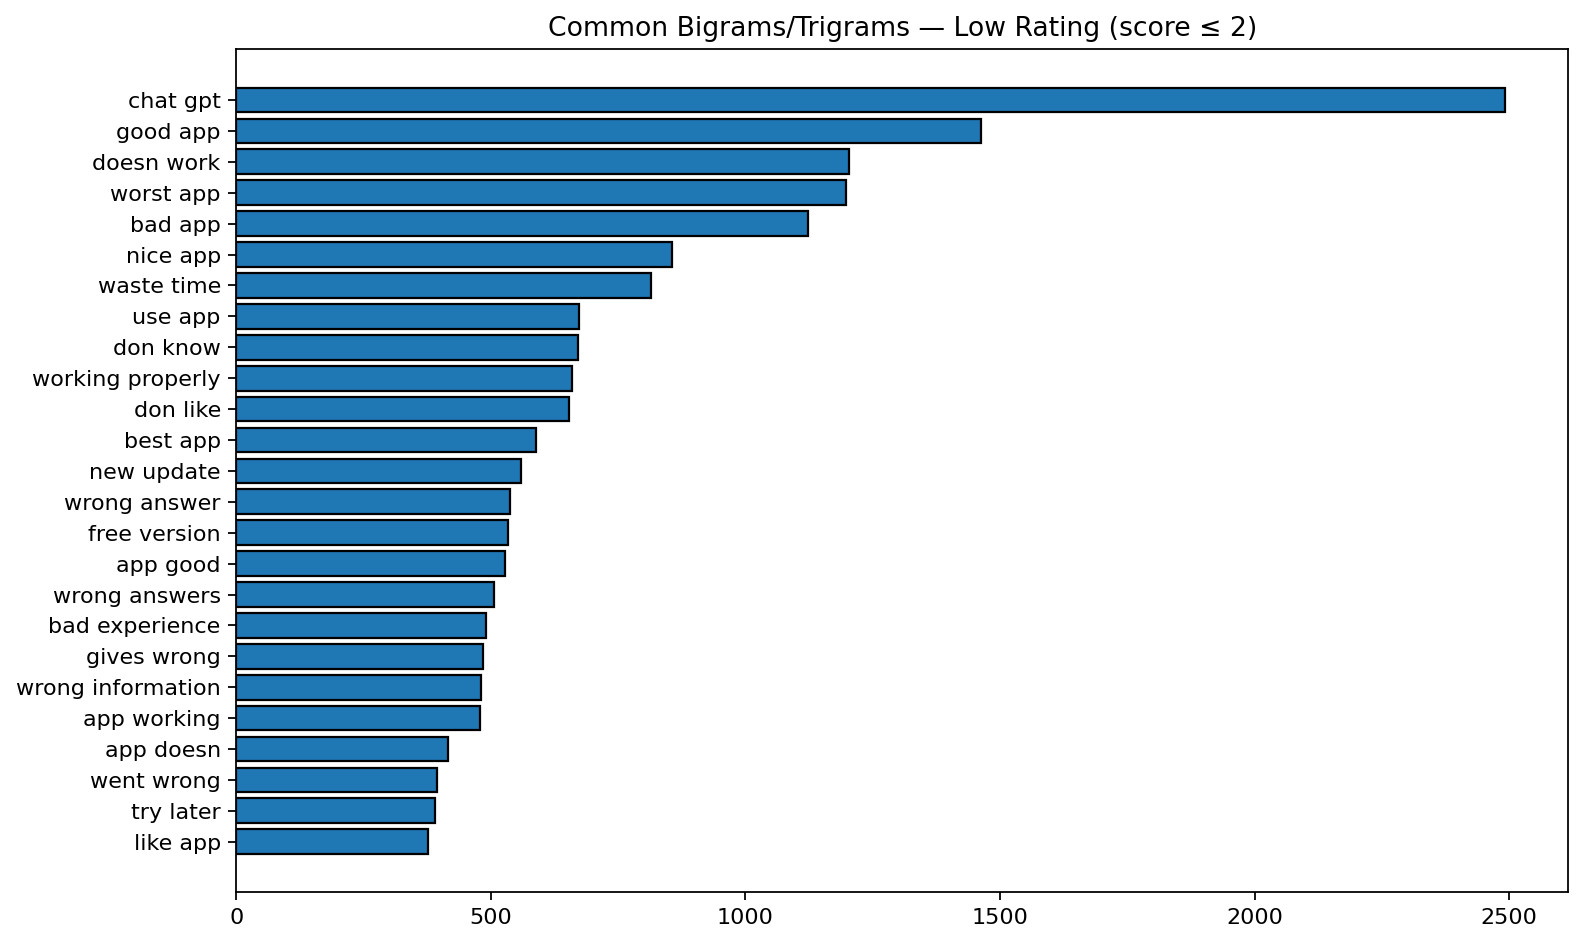

In [65]:
from sklearn.feature_extraction.text import CountVectorizer

def top_ngrams(texts, ngram_range=(2,3), top_k=25, min_df=10):
    """Return top frequent n-grams"""
    vec = CountVectorizer(stop_words="english", ngram_range=ngram_range, min_df=min_df)
    X = vec.fit_transform(texts)
    freqs = X.sum(axis=0).A1
    vocab = vec.get_feature_names_out()
    return pd.DataFrame({"ngram": vocab, "count": freqs}).sort_values("count", ascending=False).head(top_k)

# By rating
high_texts = df.loc[df["score"] >= 4, "content"].dropna().astype(str).tolist()
low_texts  = df.loc[df["score"] <= 2, "content"].dropna().astype(str).tolist()

top_high = top_ngrams(high_texts)
top_low  = top_ngrams(low_texts)

plt.figure(figsize=(10,6))
plt.barh(top_high["ngram"][::-1], top_high["count"][::-1], edgecolor="black")
plt.title("Common Bigrams/Trigrams — High Rating (score ≥ 4)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,6))
plt.barh(top_low["ngram"][::-1], top_low["count"][::-1], edgecolor="black")
plt.title("Common Bigrams/Trigrams — Low Rating (score ≤ 2)")
plt.tight_layout()
plt.show()

9. User Behavior

Rating Distribution by User Activity

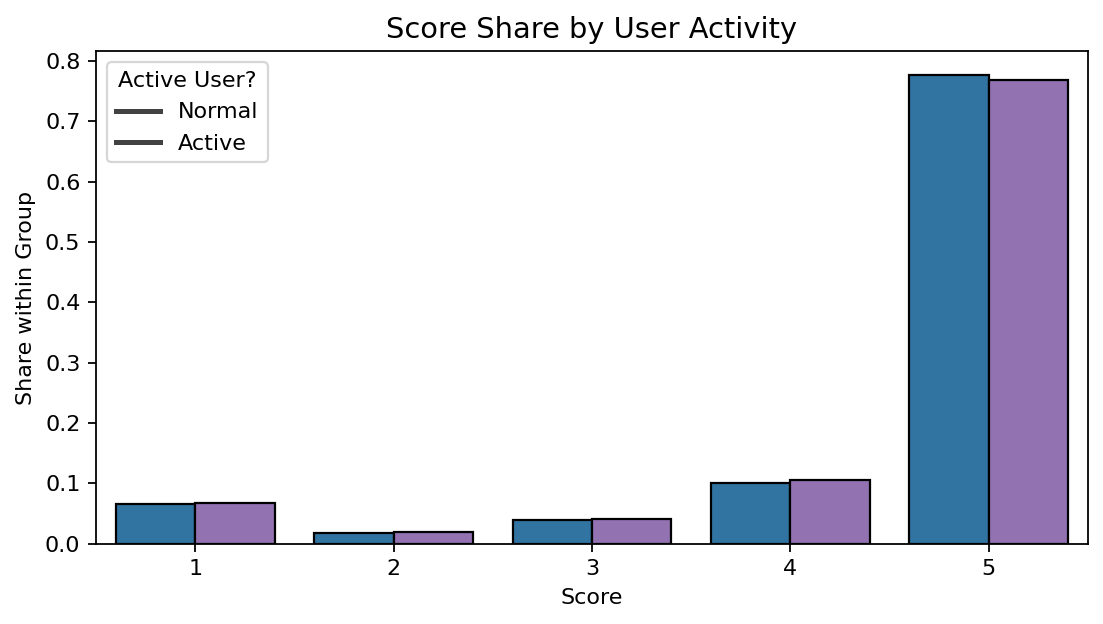

In [68]:
# Score Share by User Activity
counts = (
    df.pivot_table(index="is_active_user",
                   columns="score",
                   values="reviewId",
                   aggfunc="count",
                   fill_value=0)
    .sort_index(axis=1)
)

shares = counts.div(counts.sum(axis=1), axis=0)

tmp = shares.stack().reset_index(name="share")

# Custom palette (blue for normal, purple for active)
custom_palette = {False: "#1f77b4", True: "#9467bd"}

plt.figure(figsize=(7,4))
sns.barplot(
    x="score", y="share", hue="is_active_user",
    data=tmp, palette=custom_palette, edgecolor="black"
)
plt.title("Score Share by User Activity", fontsize=13)
plt.ylabel("Share within Group")
plt.xlabel("Score")
plt.legend(title="Active User?", labels=["Normal", "Active"])
plt.tight_layout()
plt.show()

Sentiment, Rating, and Length Change Among Active Users


=== Rating Change Summary (Active Users) ===
Increase: 18.2%
Decrease: 20.0%
No change: 61.8%

=== Summary of Change among Active Users ===
       sent_delta  score_delta  len_delta   days_gap
count   81301.000    81301.000  81301.000  81301.000
mean       -0.026       -0.076     -2.999    247.476
std         0.450        1.554     80.157    201.177
min        -1.945       -4.000   -498.000      0.000
25%        -0.287        0.000    -16.000     85.000
50%         0.000        0.000     -1.000    186.000
75%         0.215        0.000     10.000    374.000
max         1.902        4.000    498.000    805.000

Median days between first and last review: 186
Mean days between first and last review: 247.5


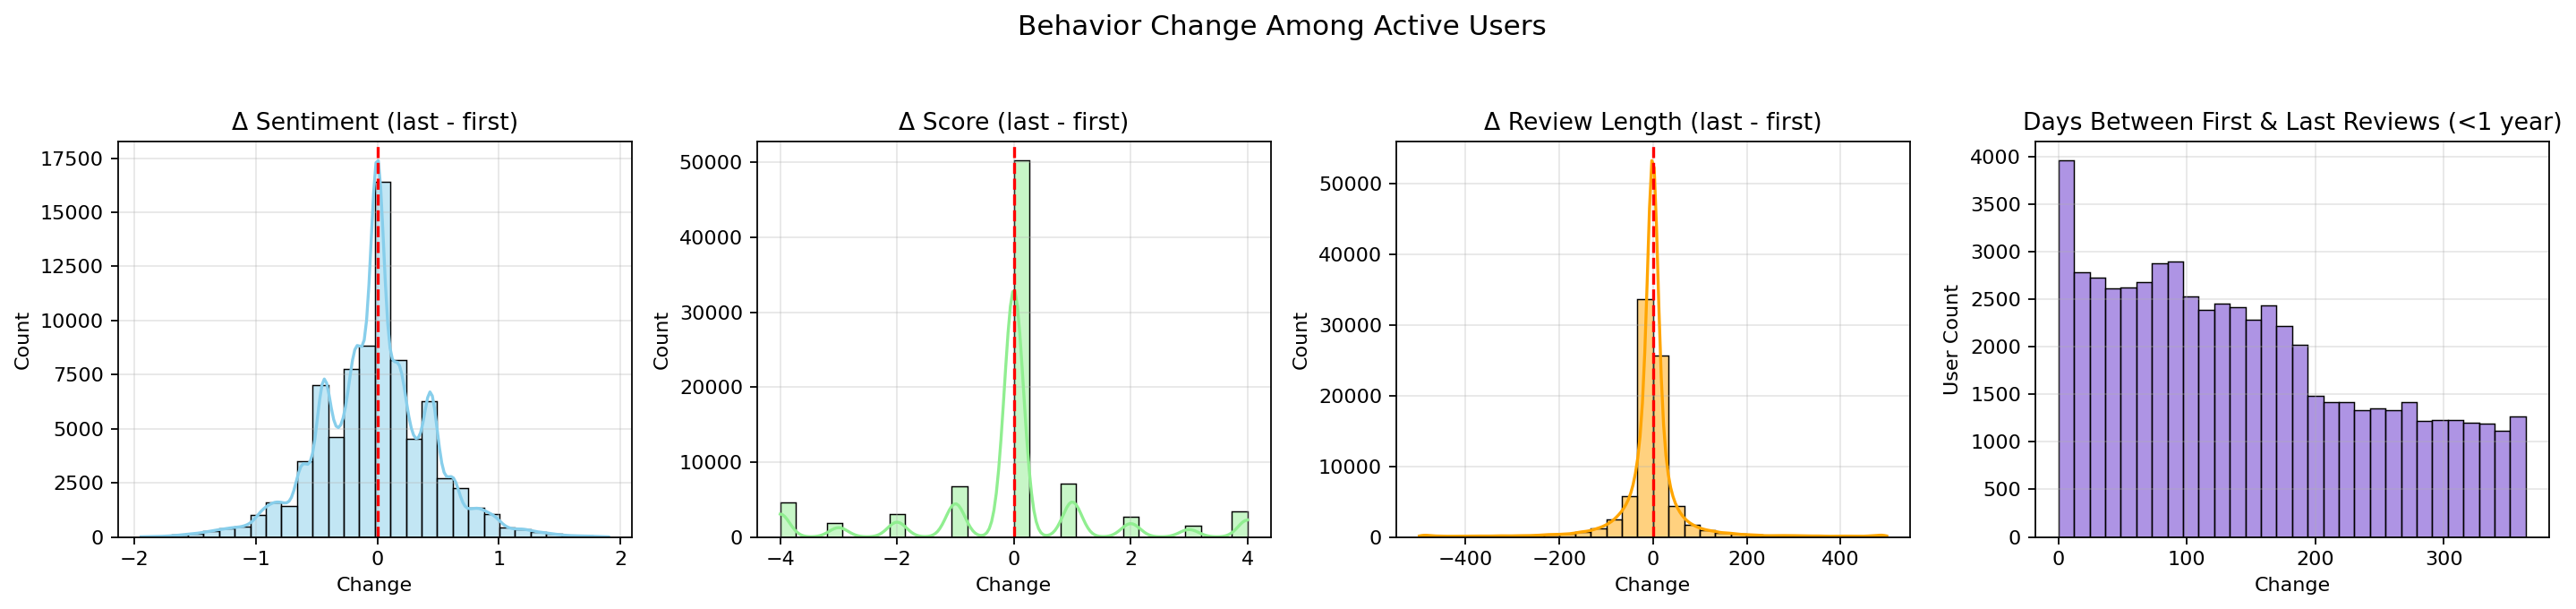

In [66]:
# Sentiment / Score / Length change among active users
if {"userName", "sentiment", "score", "content", "at"}.issubset(df.columns):

    active_users = df["userName"].value_counts()
    active_users = active_users[active_users > 1].index
    df_active = df[df["userName"].isin(active_users)].copy()

    df_active["review_length"] = df_active["content"].astype(str).apply(len)

    user_change = (
        df_active.sort_values(["userName", "at"])
        .groupby("userName")[["sentiment", "score", "review_length", "at"]]
        .agg(["first", "last"])
    )
    user_change.columns = [
        "sent_first", "sent_last",
        "score_first", "score_last",
        "len_first", "len_last",
        "date_first", "date_last"
    ]

    user_change["sent_delta"] = user_change["sent_last"] - user_change["sent_first"]
    user_change["score_delta"] = user_change["score_last"] - user_change["score_first"]
    user_change["len_delta"] = user_change["len_last"] - user_change["len_first"]
    user_change["days_gap"] = (user_change["date_last"] - user_change["date_first"]).dt.days

    up = (user_change["score_delta"] > 0).mean()
    down = (user_change["score_delta"] < 0).mean()
    same = (user_change["score_delta"] == 0).mean()

    print("Rating Change Summary (Active Users)")
    print(f"Increase: {up:.1%}")
    print(f"Decrease: {down:.1%}")
    print(f"No change: {same:.1%}")

    print("\nSummary of Change among Active Users")
    print(user_change[["sent_delta", "score_delta", "len_delta", "days_gap"]].describe().round(3))

    print(f"\nMedian days between first and last review: {user_change['days_gap'].median():.0f}")
    print(f"Mean days between first and last review: {user_change['days_gap'].mean():.1f}")

    fig, axes = plt.subplots(1, 4, figsize=(18, 4))

    sns.histplot(user_change["sent_delta"], bins=30, kde=True, color="skyblue", ax=axes[0])
    axes[0].axvline(0, color="red", linestyle="--")
    axes[0].set_title("Δ Sentiment (last - first)")

    sns.histplot(user_change["score_delta"], bins=30, kde=True, color="lightgreen", ax=axes[1])
    axes[1].axvline(0, color="red", linestyle="--")
    axes[1].set_title("Δ Score (last - first)")

    sns.histplot(user_change["len_delta"], bins=30, kde=True, color="orange", ax=axes[2])
    axes[2].axvline(0, color="red", linestyle="--")
    axes[2].set_title("Δ Review Length (last - first)")

    sns.histplot(user_change[user_change["days_gap"] < 365]["days_gap"],
                 bins=30, color="mediumpurple", ax=axes[3])
    axes[3].set_title("Days Between First & Last Reviews (<1 year)")
    axes[3].set_xlabel("Days Gap")
    axes[3].set_ylabel("User Count")

    for ax in axes:
        ax.grid(alpha=0.3)
        ax.set_xlabel("Change")

    plt.suptitle("Behavior Change Among Active Users", fontsize=14, y=1.05)
    plt.tight_layout()
    plt.show()


User Behavior Clustering

In [67]:
# User Behavior Clustering

user_features = df.groupby("userName").agg(
    review_count=("reviewId", "count"),
    avg_score=("score", "mean"),
    avg_sentiment=("sentiment", "mean"),
    avg_length=("word_count", "mean")
).reset_index()

user_features = user_features.dropna(subset=["avg_score", "avg_sentiment", "avg_length"])
user_features = user_features[user_features["review_count"] <= user_features["review_count"].quantile(0.99)]

print(f"Total unique users: {len(user_features):,}")

Total unique users: 1,207,839


In [71]:
X = user_features[["review_count", "avg_score", "avg_sentiment", "avg_length"]]
X_scaled = StandardScaler().fit_transform(X)

# Fit KMeans
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
user_features["cluster"] = kmeans.fit_predict(X_scaled)

cluster_summary = user_features.groupby("cluster")[["review_count","avg_score","avg_sentiment","avg_length"]].mean().round(2)
print("Cluster summary:")
print(cluster_summary)


Cluster summary:
         review_count  avg_score  avg_sentiment  avg_length
cluster                                                    
0                1.00       4.85           0.48        4.37
1                1.01       1.62          -0.03        8.74
2                2.54       4.54           0.44        5.26
3                1.02       3.97           0.57       55.62


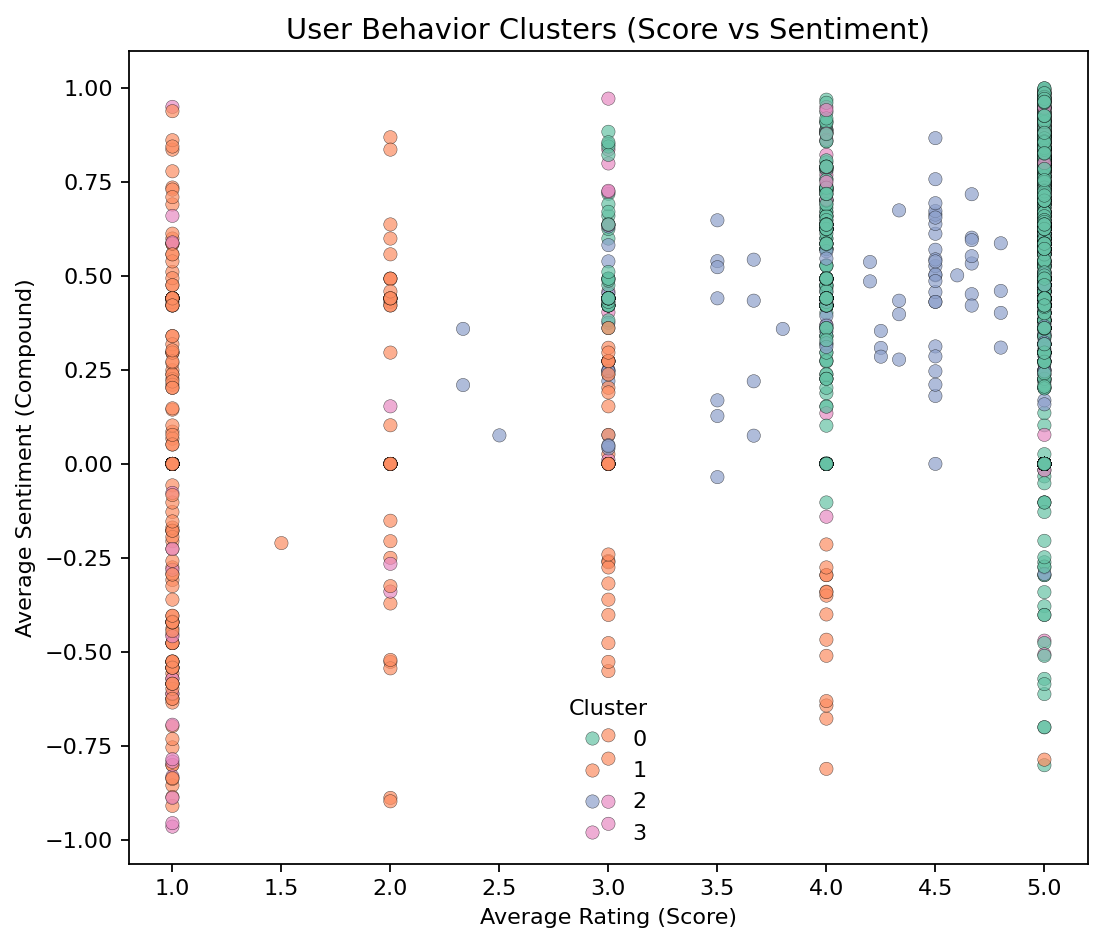

In [72]:
plt.figure(figsize=(7,6))
sns.scatterplot(
    data=user_features.sample(min(3000, len(user_features)), random_state=1),
    x="avg_score", y="avg_sentiment", hue="cluster", palette="Set2",
    alpha=0.7, edgecolor="black", linewidth=0.2
)
plt.title("User Behavior Clusters (Score vs Sentiment)", fontsize=13)
plt.xlabel("Average Rating (Score)")
plt.ylabel("Average Sentiment (Compound)")
plt.legend(title="Cluster", loc="best", frameon=False)
plt.tight_layout()
plt.show()


<Figure size 1920x800 with 0 Axes>

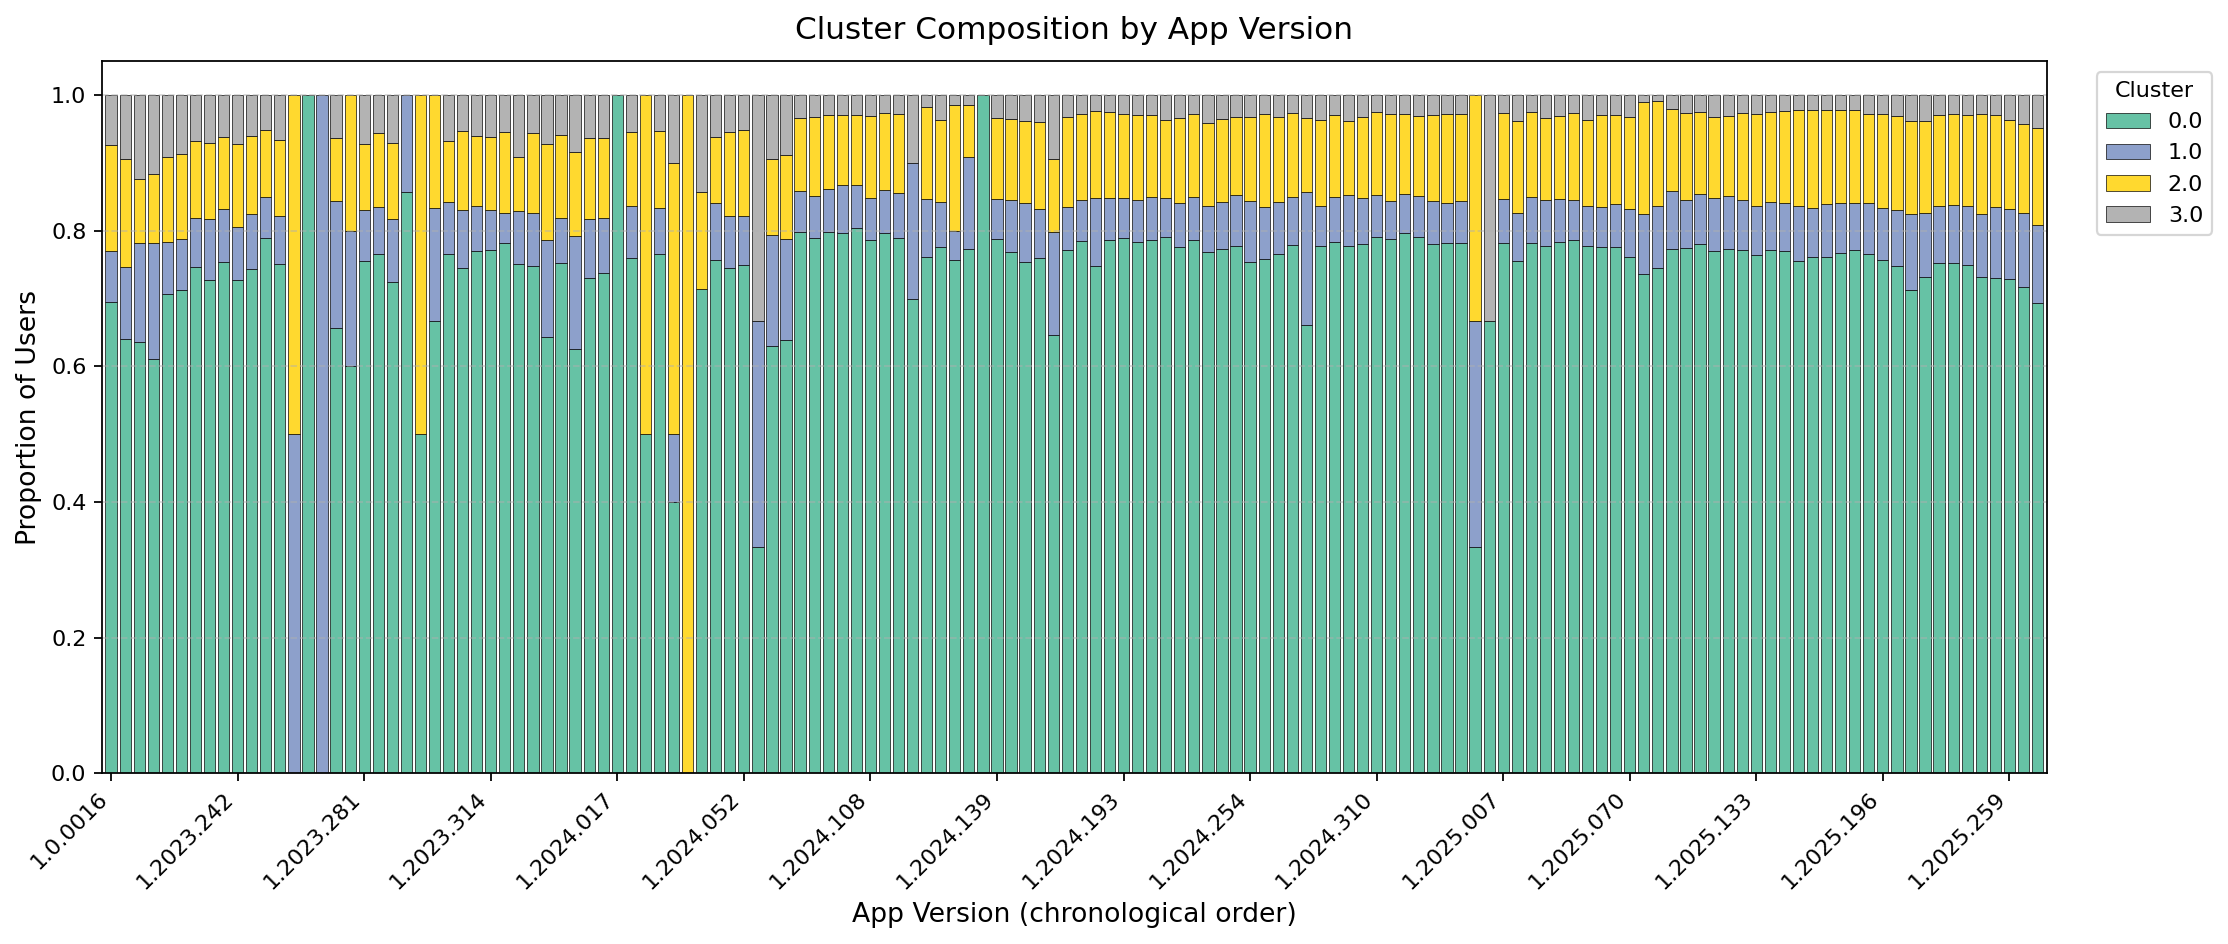

In [78]:
# Cluster Composition by App Version

version_cluster = (
    df.merge(user_features[["userName", "cluster"]], on="userName", how="left")
      .groupby("reviewCreatedVersion")["cluster"]
      .value_counts()
      .unstack(fill_value=0)
)


def version_key(v):
    parts = re.findall(r'\d+', str(v))
    return tuple(map(int, parts)) if parts else (0,)
version_cluster = version_cluster.sort_index(key=lambda s: s.map(version_key))

plt.figure(figsize=(12,5))
(
    version_cluster
    .div(version_cluster.sum(axis=1), axis=0)
    .plot(
        kind="bar",
        stacked=True,
        colormap="Set2",
        figsize=(14,6),
        width=0.8,
        edgecolor="black",
        linewidth=0.3
    )
)
plt.title("Cluster Composition by App Version", fontsize=14, pad=10)
plt.xlabel("App Version (chronological order)", fontsize=12)
plt.ylabel("Proportion of Users", fontsize=12)
plt.legend(title="Cluster", bbox_to_anchor=(1.02, 1), loc="upper left")

xticks = version_cluster.index.astype(str)
step = max(1, len(xticks)//15)
plt.xticks(range(0, len(xticks), step), xticks[::step], rotation=45, ha="right")

plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()
